In [ ]:
Custom_Masks_path = ""
Original_Masks_path = ""
Xray_path = "E:\\Users\\24968\Desktop\口腔医院\代码\project\Xray"

In [4]:
from images_prepare import *
#pre_images(resize_shape,path,include_zip)
X,X_sizes=pre_images((512,512),Xray_path,True)

In [5]:
from masks_prepare import *
#Y=pre_masks(resize_shape=(512,512),path='/content/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/Original_Masks')  ORIGINALL MASKS function
Y=pre_splitted_masks(path='E:\\Users\\24968\Desktop\口腔医院\代码\project\Custom_Masks') #Custom Splitted MASKS size 512x512

In [6]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [7]:
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

In [8]:
import cv2

import albumentations as A
#Augmention . Change what you want ! Care about Your GPU and CPU RAM

#If you get error : cannot import name '_registerMatType' from 'cv2.cv2' :
#!pip uninstall opencv-python-headless==4.5.5.62
#!pip install opencv-python-headless==4.5.2.52

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),
                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

C:\Users\urgel\AppData\Roaming\Python\Python37\site-packages\albumentations\augmentations\transforms.py:1693: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  "Using default interpolation INTER_NEAREST, which is sub-optimal."


In [9]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [10]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

26


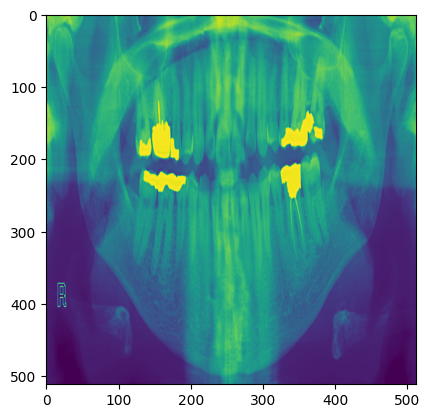

In [11]:
#Checking data X  and Y matching
plt.imshow(x_train[random_number,:,:,0])

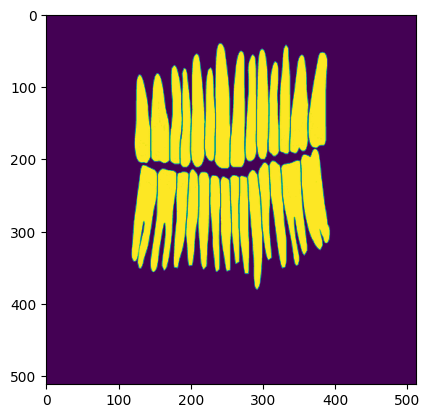

In [12]:
#Checking data X  and Y matching
plt.imshow(y_train[random_number,:,:,0])

In [13]:
from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [14]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Your choice batch and epoch
model.fit(x_train,y_train,batch_size=8,epochs=200,verbose=1)

Epoch 1/200
66/66 [==============================] - 59s 701ms/step - loss: 0.4130 - accuracy: 0.7771
Epoch 2/200
66/66 [==============================] - 39s 596ms/step - loss: 0.2434 - accuracy: 0.8490
Epoch 3/200
66/66 [==============================] - 39s 593ms/step - loss: 0.1978 - accuracy: 0.8664
Epoch 4/200
66/66 [==============================] - 39s 589ms/step - loss: 0.1820 - accuracy: 0.8723
Epoch 5/200
66/66 [==============================] - 39s 593ms/step - loss: 0.1754 - accuracy: 0.8773
Epoch 6/200
66/66 [==============================] - 39s 594ms/step - loss: 0.1627 - accuracy: 0.8794
Epoch 7/200
66/66 [==============================] - 42s 641ms/step - loss: 0.1567 - accuracy: 0.8842
Epoch 8/200
66/66 [==============================] - 46s 704ms/step - loss: 0.1544 - accuracy: 0.8846
Epoch 9/200
66/66 [==============================] - 46s 693ms/step - loss: 0.1411 - accuracy: 0.8903
Epoch 10/200
66/66 [==============================] - 46s 693ms/step - loss: 0.145

In [15]:
predict_img=model.predict(x_test)
##model.save(path)
predict=predict_img[1,:,:,0]

In [16]:
#Example Test
from sklearn.metrics import f1_score
import numpy as np
predict_img1=(predict_img>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9563758156516335

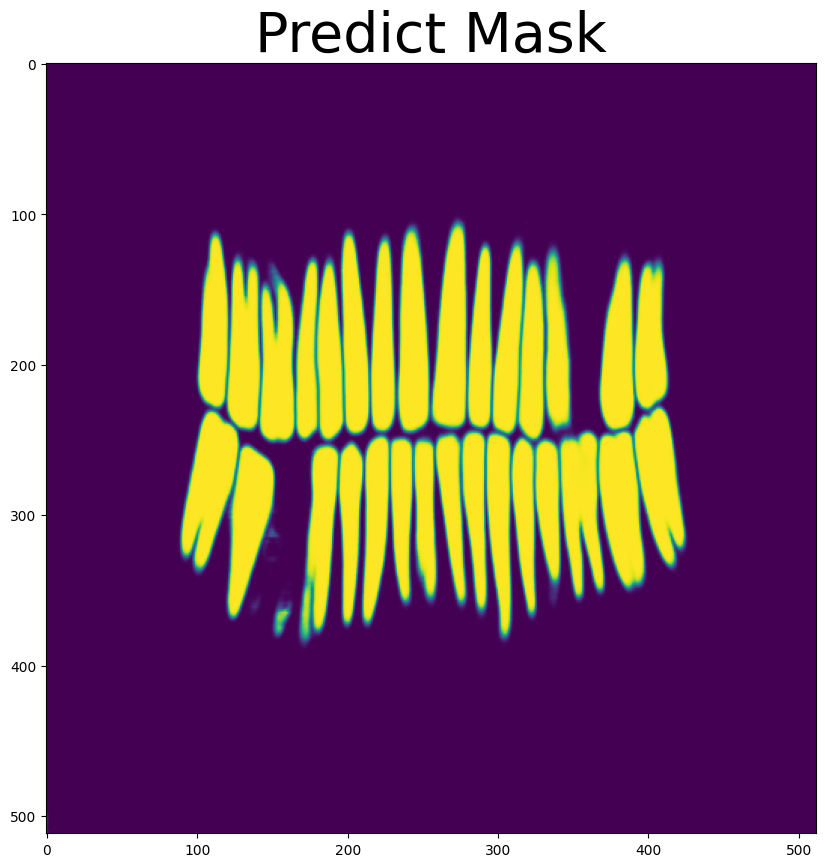

In [21]:
plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
#For CCA, we saved
plt.imsave("E:\\Users\\urgel\Desktop\\527-project\Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net-master\content/img.png",predict)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png

predict1 = cv2.resize(predict, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

mask=np.uint8(predict1*255)#
_, mask = cv2.threshold(mask, thresh=255/2, maxval=255, type=cv2.THRESH_BINARY)
cnts,hieararch=cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(img[:,:,0], cnts, -1, (255, 0, 0) , 2)
img = cv2.UMat.get(img)
cv2_imshow(img)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from CCA_Analysis import *


##Plotting - RESULT Example with CCA_Analysis
img=cv2.imread("/content/Data/Images/107.png")#original img 107.png

#load image (mask was saved by matplotlib.pyplot)
predicted=cv2.imread("/content/predict.png")

predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

cca_result,teeth_count=CCA_Analysis(img,predicted,3,2)
cv2_imshow(cca_result)

In [ ]:
print(teeth_count,"Teeth Count")

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model, '/content/drive/MyDrive/dental_xray_seg.h5')